# DEADLINE - 11.11.2024 

In [1]:
import numpy as np
import scipy.stats
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as ss
# import yfinance as yf 

N = scipy.stats.norm.cdf
n = scipy.stats.norm.pdf
sns.set_style("darkgrid")

np.random.seed(1)

## Task 2.1
Compare the convergence of approximate and exact CRR and JR binomial trees to the Black-Scholes price for different parameter sets.

- Konrad-Ritchken trinomial trees - probabilities
- Add some conclusions (1 or 2)

In [18]:
class BinomialTree():
    def __init__(self,S0,K,r,sigma,T,N):
        self.S0 = S0
        self.K = K
        self.r = r
        self.sigma = sigma
        self.T = T
        self.N = N #number of steps
        self.delta_t = T/N
        self.CRR_u_approx = np.exp(sigma*np.sqrt(self.delta_t))
        self.CRR_d_approx = 1/self.CRR_u_approx
        self.CRR_u = (np.exp(-r*self.delta_t) + np.exp((r + sigma**2)*self.delta_t) + np.sqrt((np.exp(-r*self.delta_t) + np.exp((r+ sigma**2)*self.delta_t))**2-4))/2
        self.CRR_d = 1/self.CRR_u
        self.JR_u = np.exp(r*self.delta_t)*(1 + np.sqrt(np.exp(self.delta_t*sigma**2) - 1))
        self.JR_d = np.exp(r*self.delta_t)*(1 - np.sqrt(np.exp(self.delta_t*sigma**2) - 1))
        self.JR_u_approx = np.exp((r - sigma**2/2)*self.delta_t + sigma*np.sqrt(self.delta_t))
        self.JR_d_approx = np.exp((r - sigma**2/2)*self.delta_t - sigma*np.sqrt(self.delta_t))

    def european_price_option(self, option_type, method = 'CRR_approx'):
        if method == 'CRR_approx':
            u = self.CRR_u_approx
            d = self.CRR_d_approx
            q = (np.exp(self.r*self.delta_t) - d)/(u-d)
        elif method == 'CRR':
            u = self.CRR_u
            d = self.CRR_d
            q = (np.exp(self.r*self.delta_t) - d)/(u-d)
        elif method == 'JR':
            u = self.JR_u
            d = self.JR_d
            q = (np.exp(self.r*self.delta_t) - d)/(u-d)
        elif method == 'JR_approx':
            u = self.JR_u_approx
            d= self.JR_d_approx
            q = (np.exp(self.r*self.delta_t) - d)/(u-d)

        stock_tree = np.zeros((self.N + 1, self.N + 1))
        for i in range(self.N + 1):
            for j in range(i + 1):
                stock_tree[j, i] = self.S0 * (u ** (i - j)) * (d ** j)
        
        # Step 2: Initialize option price tree at maturity
        option_tree = np.zeros((self.N + 1, self.N + 1))
        if option_type == 'call':
            option_tree[:, self.N] = np.maximum(0, stock_tree[:, self.N] - self.K)
        elif option_type == 'put':
            option_tree[:, self.N] = np.maximum(0, self.K - stock_tree[:, self.N])

        # Step 3: Backward induction for option price at each node
        for i in range(self.N - 1, -1, -1):
            for j in range(i + 1):
                option_tree[j, i] = np.exp(-self.r * self.delta_t) * (q * option_tree[j, i + 1] + (1 - q) * option_tree[j + 1, i + 1])

        return option_tree[0, 0]
    
    def american_price_option(self, option_type, method = 'CRR_approx'):
        if method == 'CRR_approx':
            u = self.CRR_u_approx
            d = self.CRR_d_approx
            q = (np.exp(self.r*self.delta_t) - d)/(u-d)
        elif method == 'CRR':
            u = self.CRR_u
            d = self.CRR_d
            q = (np.exp(self.r*self.delta_t) - d)/(u-d)
        elif method == 'JR':
            u = self.JR_u
            d = self.JR_d
            q = (np.exp(self.r*self.delta_t) - d)/(u-d)
        elif method == 'JR_approx':
            u = self.JR_u_approx
            d= self.JR_d_approx
            q = (np.exp(self.r*self.delta_t) - d)/(u-d)

        stock_tree = np.zeros((self.N + 1, self.N + 1))
        for i in range(self.N + 1):
            for j in range(i + 1):
                stock_tree[j, i] = self.S0 * (u ** (i - j)) * (d ** j)
        
        # Step 2: Initialize option price tree at maturity
        option_tree = np.zeros((self.N + 1, self.N + 1))
        if option_type == 'call':
            option_tree[:, self.N] = np.maximum(0, stock_tree[:, self.N] - self.K)
        elif option_type == 'put':
            option_tree[:, self.N] = np.maximum(0, self.K - stock_tree[:, self.N])

        # Step 3: Backward induction for american option price
        for i in range(self.N - 1, -1, -1):
            for j in range(i + 1):
                # Calculate the value of holding the option
                hold_value = np.exp(-self.r * self.delta_t) * (q * option_tree[j, i + 1] + (1 - q) * option_tree[j + 1, i + 1])

                # Calculate the intrinsic value of exercising the option immediately
                if option_type == 'call':
                    exercise_value = max(0, stock_tree[j, i] - self.K)
                elif option_type == 'put':
                    exercise_value = max(0, self.K - stock_tree[j, i])

                # Take the maximum of holding and exercising
                option_tree[j, i] = max(hold_value, exercise_value)

        return option_tree[0, 0]
    
 #outside the class   
def price_changing_N(S0,K,r,sigma,T,Nmax, option_type, method = 'CRR_approx'):
    ranging = range(5,Nmax +1,1)
    call_price_N = np.zeros(len(ranging))

    for i, N in enumerate(ranging):
        binomTree = BinomialTree(S0,K,r,sigma,T,N)
        call_price_N[i] = binomTree.european_price_option(option_type, method)
    return call_price_N

def american_price_changing_N(S0,K,r,sigma,T,Nmax, option_type, method = 'CRR_approx'):
    ranging = range(5,Nmax +1,1)
    call_price_N = np.zeros(len(ranging))

    for i, N in enumerate(ranging):
        binomTree = BinomialTree(S0,K,r,sigma,T,N)
        call_price_N[i] = binomTree.american_price_option(option_type, method)
    return call_price_N


In [3]:
def call_price(S, K, T, r, sigma):
    N = ss.norm.cdf
    d1 = (np.log(S/K) + (r + sigma**2/2)*T) / (sigma*np.sqrt(T))
    d2 = d1 - sigma * np.sqrt(T)
    return S * N(d1) - K * np.exp(-r*T)* N(d2)

def put_price(S, K, T, r, sigma):
    N = ss.norm.cdf
    d1 = (np.log(S/K) + (r + sigma**2/2)*T) / (sigma*np.sqrt(T))
    d2 = d1 - sigma* np.sqrt(T)
    return K*np.exp(-r*T)*N(-d2) - S*N(-d1)

In [12]:
S0 = 70    
K = 70    
T = 0.25    
r = 0.05         
sigma = 0.25     
Nmax = 200      

In [13]:
BS = put_price(S0, K, T, r, sigma)

In [14]:
prices_CRR_approx = price_changing_N(S0,K,r,sigma,T,Nmax, option_type = 'put', method = 'CRR_approx')

In [15]:
prices_CRR = price_changing_N(S0,K,r,sigma,T,Nmax, option_type = 'put', method = 'CRR')

In [16]:
prices_JR_approx = price_changing_N(S0,K,r,sigma,T,Nmax, option_type = 'put', method = 'JR_approx')

In [17]:
prices_JR = price_changing_N(S0,K,r,sigma,T,Nmax, option_type = 'put', method = 'JR')

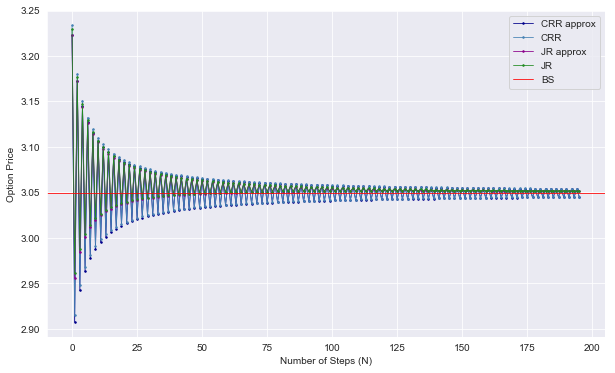

In [ ]:
plt.figure(figsize=(10, 6))
plt.plot(prices_CRR_approx, 'o-',color = 'darkblue',markersize = 1.5,linewidth = 0.8,  label = 'CRR approx')
plt.plot(prices_CRR, 'o-',color = 'steelblue',markersize = 1.5,linewidth = 0.8,  label = 'CRR')
plt.plot(prices_JR_approx ,'o-',color = 'darkmagenta' ,markersize = 1.5,linewidth = 0.8,  label = 'JR approx')
plt.plot(prices_JR , 'o-',color ='forestgreen', markersize = 1.5,linewidth = 0.8, label = 'JR')
plt.axhline(BS, label = 'BS',color= 'red',linewidth = 0.8)

plt.xlabel("Number of Steps (N)")
plt.ylabel("Option Price")
# plt.title("CRR approx Binomial Model for European Call Option")
plt.legend()
plt.show()

In [ ]:
am_prices_CRR_approx = american_price_changing_N(S0,K,r,sigma,T,Nmax, option_type = 'put', method = 'CRR_approx')
am_prices_CRR = american_price_changing_N(S0,K,r,sigma,T,Nmax, option_type = 'put', method = 'CRR')
am_prices_JR_approx = american_price_changing_N(S0,K,r,sigma,T,Nmax, option_type = 'put', method = 'JR_approx')
am_prices_JR = american_price_changing_N(S0,K,r,sigma,T,Nmax, option_type = 'put', method = 'JR')


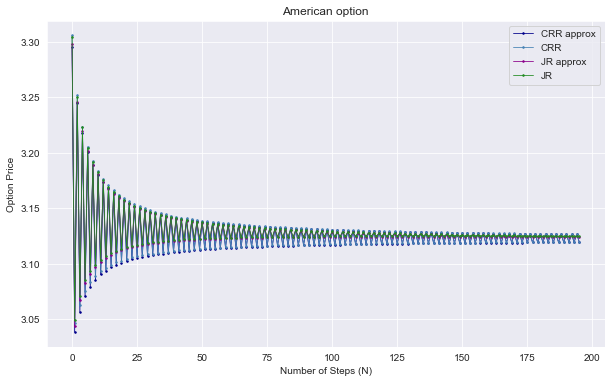

In [ ]:
plt.figure(figsize=(10, 6))
plt.plot(am_prices_CRR_approx, 'o-',color = 'darkblue',markersize = 1.5,linewidth = 0.8,  label = 'CRR approx')
plt.plot(am_prices_CRR, 'o-',color = 'steelblue',markersize = 1.5,linewidth = 0.8,  label = 'CRR')
plt.plot(am_prices_JR_approx ,'o-',color = 'darkmagenta' ,markersize = 1.5,linewidth = 0.8,  label = 'JR approx')
plt.plot(am_prices_JR , 'o-',color ='forestgreen', markersize = 1.5,linewidth = 0.8, label = 'JR')

plt.xlabel("Number of Steps (N)")
plt.ylabel("Option Price")
plt.title("American option")
plt.legend()
plt.show()

## Task 2.2
Compare the convergence of Boyle and Kamrad-Ritchken trinomial trees to the Black-Scholes price for different parameter sets. Compare with the results for Task 2.1

In [ ]:
class BoyleTrinomialTree():
    def __init__(self,S0,K,r,sigma,lam,T,N):
        self.S0 = S0
        self.K = K
        self.r = r
        self.sigma = sigma
        self.lam = lam #stretch parameter
        self.T = T
        self.N = N #number of steps
        self.delta_t = T/N
        self.u = np.exp(lam*sigma*np.sqrt(self.delta_t))
        self.d = 1/self.u
        self.m = 1
        self.q_u = ((np.exp((2*r + sigma**2)*self.delta_t) - np.exp(r*self.delta_t))*self.u - (np.exp(r*self.delta_t) - 1))/((self.u-1)*(self.u**2-1))
        self.q_d = ((np.exp((2*r + sigma**2)*self.delta_t) - np.exp(r*self.delta_t))*self.u**2 - (np.exp(r*self.delta_t) - 1)*self.u**3)/((self.u-1)*(self.u**2-1))
        self.q_m = 1 - self.q_u - self.q_d

    def european_price_option(self, option_type):

        stock_tree = np.zeros((2 * self.N + 1, self.N + 1))
        stock_tree[self.N, 0] = self.S0  # Initial stock price at root
        for i in range(self.N + 1):
            for j in range(-i, i + 1, 1):
                #not konow why does it work
                stock_tree[self.N + j, i] = self.S0 * (self.u ** max(j, 0)) * (self.d ** max(-j, 0))
        
        
        option_tree = np.zeros((2*self.N + 1, self.N + 1))
        for j in range(-self.N, self.N + 1):
            if option_type == 'call':
                option_tree[self.N + j, self.N] = np.maximum(0, stock_tree[self.N + j, self.N] - self.K)
            elif option_type == 'put':
                option_tree[self.N + j, self.N] = np.maximum(0, self.K - stock_tree[self.N + j, self.N])

        # Step 3: Backward induction 
        for i in range(self.N - 1, -1, -1):
            for j in range(-i, i + 1):
                option_tree[self.N + j, i] = (np.exp(-self.r * self.delta_t) * 
                                              (self.q_u * option_tree[self.N + j + 1, i + 1] + 
                                               self.q_m * option_tree[self.N + j, i + 1] +
                                               self.q_d + option_tree[self.N + j - 1, i + 1]))
        # print(option_tree)

        return option_tree[self.N, 0]
    
    def american_price_option(self, option_type):

        stock_tree = np.zeros((2 * self.N + 1, self.N + 1))
        stock_tree[self.N, 0] = self.S0  # Initial stock price at root
        for i in range(self.N + 1):
            for j in range(-i, i + 1, 1):
                stock_tree[self.N + j, i] = self.S0 * (self.u ** max(j, 0)) * (self.d ** max(-j, 0))
        
        option_tree = np.zeros((2*self.N + 1, self.N + 1))
        for j in range(-self.N, self.N + 1):
            if option_type == 'call':
                option_tree[self.N + j, self.N] = np.maximum(0, stock_tree[self.N + j, self.N] - self.K)
            elif option_type == 'put':
                option_tree[self.N + j, self.N] = np.maximum(0, self.K - stock_tree[self.N + j, self.N])


        # Step 3: Backward induction for american option price
        for i in range(self.N - 1, -1, -1):
            for j in range(-i, i + 1):
                hold_value = (np.exp(-self.r * self.delta_t) * 
                                    (self.q_u * option_tree[self.N + j + 1, i + 1] + 
                                     self.q_m * option_tree[self.N + j, i + 1] +
                                     self.q_d + option_tree[self.N + j - 1, i + 1]))

                if option_type == 'call':
                    exercise_value = max(0, stock_tree[self.N + j, i] - self.K)
                elif option_type == 'put':
                    exercise_value = max(0, self.K - stock_tree[self.N + j, i])


                option_tree[self.N + j, i] = max(hold_value, exercise_value)

        return option_tree[self.N, 0]

# should change the mięsko w środku
class KRTrinomialTree():
    def __init__(self,S0,K,r,sigma,lam,T,N):
        self.S0 = S0
        self.K = K
        self.r = r
        self.sigma = sigma
        self.lam = lam #stretch parameter
        self.T = T
        self.N = N #number of steps
        self.delta_t = T/N
        self.u = np.exp(lam*sigma*np.sqrt(self.delta_t))
        self.d = 1/self.u
        self.m = 1
        self.q_u = ((np.exp((2*r + sigma**2)*self.delta_t) - np.exp(r*self.delta_t))*self.u - (np.exp(r*self.delta_t) - 1))/((self.u-1)*(self.u**2-1))
        self.q_d = ((np.exp((2*r + sigma**2)*self.delta_t) - np.exp(r*self.delta_t))*self.u**2 - (np.exp(r*self.delta_t) - 1)*self.u**3)/((self.u-1)*(self.u**2-1))
        self.q_m = 1 - self.q_u - self.q_d

    def european_price_option(self, option_type):

        stock_tree = np.zeros((2 * self.N + 1, self.N + 1))
        stock_tree[self.N, 0] = self.S0  # Initial stock price at root
        for i in range(self.N + 1):
            for j in range(-i, i + 1, 1):
                #not konow why does it work
                stock_tree[self.N + j, i] = self.S0 * (self.u ** max(j, 0)) * (self.d ** max(-j, 0))
        
        
        option_tree = np.zeros((2*self.N + 1, self.N + 1))
        for j in range(-self.N, self.N + 1):
            if option_type == 'call':
                option_tree[self.N + j, self.N] = np.maximum(0, stock_tree[self.N + j, self.N] - self.K)
            elif option_type == 'put':
                option_tree[self.N + j, self.N] = np.maximum(0, self.K - stock_tree[self.N + j, self.N])

        # Step 3: Backward induction 
        for i in range(self.N - 1, -1, -1):
            for j in range(-i, i + 1):
                option_tree[self.N + j, i] = (np.exp(-self.r * self.delta_t) * 
                                              (self.q_u * option_tree[self.N + j + 1, i + 1] + 
                                               self.q_m * option_tree[self.N + j, i + 1] +
                                               self.q_d + option_tree[self.N + j - 1, i + 1]))
        # print(option_tree)

        return option_tree[self.N, 0]
    
    def american_price_option(self, option_type):

        stock_tree = np.zeros((2 * self.N + 1, self.N + 1))
        stock_tree[self.N, 0] = self.S0  # Initial stock price at root
        for i in range(self.N + 1):
            for j in range(-i, i + 1, 1):
                stock_tree[self.N + j, i] = self.S0 * (self.u ** max(j, 0)) * (self.d ** max(-j, 0))
        
        option_tree = np.zeros((2*self.N + 1, self.N + 1))
        for j in range(-self.N, self.N + 1):
            if option_type == 'call':
                option_tree[self.N + j, self.N] = np.maximum(0, stock_tree[self.N + j, self.N] - self.K)
            elif option_type == 'put':
                option_tree[self.N + j, self.N] = np.maximum(0, self.K - stock_tree[self.N + j, self.N])


        # Step 3: Backward induction for american option price
        for i in range(self.N - 1, -1, -1):
            for j in range(-i, i + 1):
                hold_value = (np.exp(-self.r * self.delta_t) * 
                                    (self.q_u * option_tree[self.N + j + 1, i + 1] + 
                                     self.q_m * option_tree[self.N + j, i + 1] +
                                     self.q_d + option_tree[self.N + j - 1, i + 1]))

                if option_type == 'call':
                    exercise_value = max(0, stock_tree[self.N + j, i] - self.K)
                elif option_type == 'put':
                    exercise_value = max(0, self.K - stock_tree[self.N + j, i])


                option_tree[self.N + j, i] = max(hold_value, exercise_value)

        return option_tree[self.N, 0]   



#need to be changed on trinomial tree  
def trinomial_pricing(S0,K,r,sigma,T,Nmax, option_type, method = 'CRR_approx'):
    ranging = range(5,Nmax +1,1)
    call_price_N = np.zeros(len(ranging))

    for i, N in enumerate(ranging):
        binomTree = BinomialTree(S0,K,r,sigma,T,N)
        call_price_N[i] = binomTree.european_price_option(option_type, method)
    return call_price_N

def american_trinomial_pricing(S0,K,r,sigma,T,Nmax, option_type, method = 'CRR_approx'):
    ranging = range(5,Nmax +1,1)
    call_price_N = np.zeros(len(ranging))

    for i, N in enumerate(ranging):
        binomTree = BinomialTree(S0,K,r,sigma,T,N)
        call_price_N[i] = binomTree.american_price_option(option_type, method)
    return call_price_N


In [37]:
S0 = 102
K = 100
r = 0.1
sigma = 0.2
lam = 1.225
T = 0.25
N = 5

In [38]:
boyle = BoyleTrinomialTree(S0,K,r,sigma,lam,T,N)
boyle_price = boyle.european_price_option('put')    

[[  0.           0.           0.           0.           0.
   22.43979403]
 [  0.           0.           0.           0.          33.45843536
   18.07221803]
 [  0.           0.           0.          48.50490545  25.81162651
   13.45869478]
 [  0.           0.          68.34676993  35.39512143  17.73421
    8.58537447]
 [  0.          93.87376771  47.05469745  22.53213548   9.94805853
    3.43762739]
 [126.16498621  61.11883525  27.99032847  11.50714056   3.7209937
    0.        ]
 [  0.          34.3452093   13.40557377   4.21165226   0.30051155
    0.        ]
 [  0.           0.           5.05247448   0.80822984   0.30051155
    0.        ]
 [  0.           0.           0.           0.80822984   0.30051155
    0.        ]
 [  0.           0.           0.           0.           0.30051155
    0.        ]
 [  0.           0.           0.           0.           0.
    0.        ]]


In [40]:
boyle_price

126.1649862061541